In [1]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Gegeben seien Messdaten eines dynamischen technischen Prozesses mit einem Eingangssignal $u_{1}$ und einem Ausgangssignal $y_{1}$

In [153]:
A = np.array([[0.5, -0.5], [0.5, 0.5]])
B = np.array([[0], [1]])
C = np.array([[0, 1]])

u =[[np.random.randint(-20,20)/10]*l[0] for l in np.random.randint(20,50,(10,1))]
u = np.hstack(u).reshape(-1,1)

x = [np.zeros((2,1))]
y = []

for uk in u:
    x_new = A.dot(x[-1]) + B.dot(uk.reshape(1,1))
    y.append(C.dot(x[-1]) + np.random.normal(0,0.1))
    x.append(x_new)
y = np.vstack(y)
df = pd.DataFrame(data=np.hstack([u,y]),columns=['u','y'])
pkl.dump(df,open('dynamic_data.pkl','wb'))

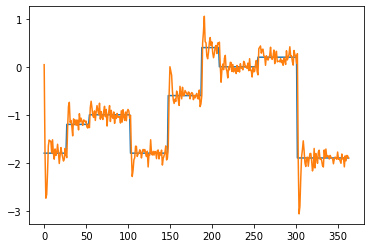

In [154]:
D = pkl.load(open('dynamic_data.pkl','rb'))

fig,ax = plt.subplots(1,1)
ax.plot(D['u'])
ax.plot(D['y'])

Als Modellierungsansatz wird ein dynamisches Modell zweiter Ordnung gewählt:
$$
\begin{bmatrix}x_{1,k+1}\\x_{2,k+1}\end{bmatrix} = 
\begin{bmatrix}a_{11} & a_{12}\\a_{21} & a_{22}\end{bmatrix}
\begin{bmatrix}x_{1,k}\\x_{2,k}\end{bmatrix}
+
\begin{bmatrix}b_{1,1}\\b_{2,1}\end{bmatrix}
u_{k}
$$
$$
y_{k} = \begin{bmatrix}c_{1,1} & c_{1,2}\end{bmatrix} \begin{bmatrix}x_{1,k}\\x_{2,k}\end{bmatrix}
$$

In [155]:
x = cs.MX.sym('x',2,1)
u = cs.MX.sym('u',1,1)

A = cs.MX.sym('A',2,2)
B = cs.MX.sym('B',2,1)
C = cs.MX.sym('C',1,2)

x_new = cs.mtimes(A,x) + cs.mtimes(B,u)
y = cs.mtimes(C,x)

theta = cs.vcat([A.reshape((-1,1)),B.reshape((-1,1)),C.reshape((-1,1))])

f_model = cs.Function('f_model',[u,x,A,B,C],[x_new,y],['u','x','A','B','C'],['x_new','y'])


Die Ausgabe des Modells y hängt nun vom Zustand im vorigen Zustand ab. 

In [156]:
opti = cs.Opti() # 
A = opti.variable(2,2)
B = opti.variable(2,1)
C = opti.variable(1,2)

L = 0

x = [np.zeros((2,1))]
y = []

for k in range(0,len(D)):
    u_k = D.loc[k][['u']].values.reshape((1,1))
    
    y_k = D.loc[k]['y']
    
    est = f_model(u=u_k, x = x[-1], A=A,B=B,C=C)
    x.append(est['x_new'])
    y.append(est['y'])

    L = L + 0.5*(est['y'] - y_k)**2
    
opti.minimize(L)
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

In [157]:
A_opt = sol.value(A)
B_opt = sol.value(B)
C_opt = sol.value(C)

In [158]:
A_opt
B_opt
C_opt

array([0., 0.])

In [167]:
opti.set_initial(A,np.random.randn(2,2))
opti.set_initial(B,np.random.randn(2,1))
opti.set_initial(C,np.random.randn(1,2))

In [168]:
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

In [169]:
A_opt = sol.value(A)
B_opt = sol.value(B)
C_opt = sol.value(C)

In [170]:
x = [np.zeros((2,1))]
y = []

for k in range(0,len(D)):
    u_k = D.loc[k][['u']].values.reshape((1,1))
    
    y_k = D.loc[k]['y']
    
    est = f_model(u=u_k, x = x[-1], A=A_opt,B=B_opt,C=C_opt)
    x.append(est['x_new'])
    y.append(est['y'])

In [171]:
y_est = np.vstack(y)

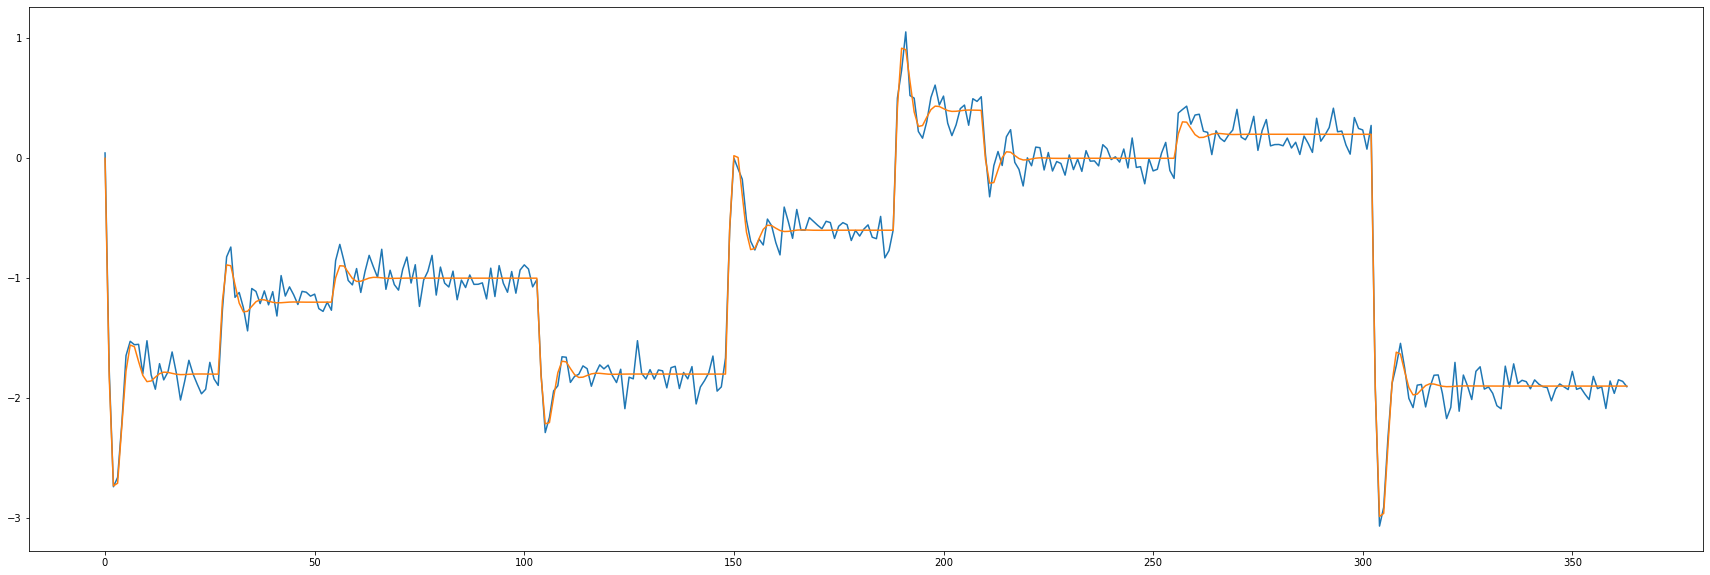

In [175]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches((30,10))
ax.plot(D['y'])
ax.plot(y_est)


In [173]:
A_opt

array([[ 0.58367828,  0.1558133 ],
       [-1.68777196,  0.40859704]])

In [174]:
dyn_model = {'f_model':f_model,
             'A_opt':A_opt,
             'B_opt':B_opt,
             'C_opt':C_opt}

pkl.dump(dyn_model,open('dyn_model.pkl','wb') )